# Descriptive Figures

This notebook reads in the processed data curated by from PubMed Central and builds some descriptive figures about it.

In [4]:
### We start by importing a lot of important python packages and loading the csv into a pandas dataframe
from __future__ import print_function #We need this for something...

import datetime as dt
from IPython.display import display
import itertools as it
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import date2num
%matplotlib inline
import numpy as np
import os
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import sys
import ipywidgets as widgets
from zipfile import ZipFile

# Load the autoreload extension so the following
# scripts are automatically re-loaded when you
# run the notebook
# (This isn't super important for the final product
# but is very valuable to include during development)
%load_ext autoreload
%autoreload 2

# Import local visualisation scripts
sys.path.append('../scripts')
from das_visualisations import pubs_over_time, get_mandate_dates, make_lots_of_plots

# Set style for figures
sns.set(style='white', font_scale = 1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


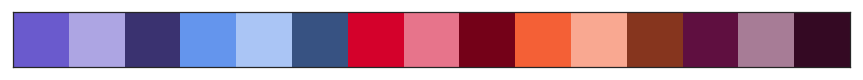

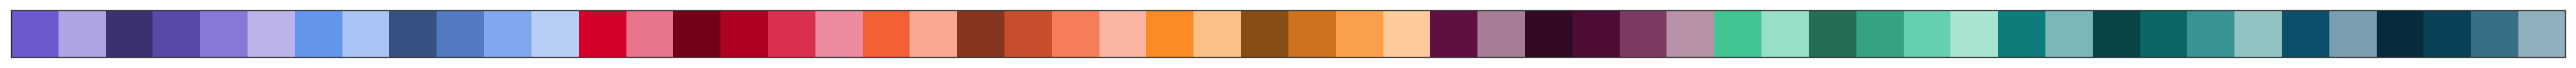

In [5]:
# Define colour palette for seaborn plotting

# The main colour palette is linked at
# https://coolors.co/6a5acd-6495ed-d4012b-f46036-5f0f40
# The light colour palette was created by taking the alternate 
# shade that was 5 steps above the main colour and is linked at
# https://coolors.co/ada5e3-aac5f5-e7748b-f9a891-a77c96
# The dark colour palette was created by taking the alternate 
# shade that was 5 steps below the main colour and is linked at
# https://coolors.co/3a3270-375282-740118-86351e-a77c96

palette=['#6A5ACD', '#ada5e3', '#3a3270',
         '#6495ED', '#aac5f5', '#375282',
         '#d4012b', '#e7748b', '#740118',
         '#f46036', '#f9a891', '#86351e',
         '#5f0f40', '#a77c96','#340923']
sns.set_palette(palette)
sns.palplot(sns.color_palette())

# We need to make a more nuanced one though that works for the 
# 5 das classes though :)
# Lets keep the first 3 colours the same, and then add in 5 more
# for the different classes.
# The 3rd colour will correspond to das class 0, and then the
# 4th - 8th will be classes 1 - 5.
# The main colour palette is linked at
# https://coolors.co/6a5acd-6495ed-d4012b-f46036-5f0f40
# The light colour palette was created by taking the alternate 
# shade that was 5 steps above the main colour and is linked at
# https://coolors.co/ada5e3-aac5f5-e7748b-f9a891-a77c96
# The dark colour palette was created by taking the alternate 
# shade that was 5 steps below the main colour and is linked at
# https://coolors.co/3a3270-375282-740118-86351e-340923


# CLASS 1: https://coolors.co/574aa8-527ac2-ae0124-c84f2d-4e0d35
# CLASS 2: https://coolors.co/6a5acd-6495ed-d4012b-f46036-5f0f40
# CLASS 3 (2): https://coolors.co/8578d6-80a8f0-db2f51-f67c5a-7c3a62
# CLASS 4: https://coolors.co/a096df-9cbbf3-e35d78-f8997f-996685
# CLASS 5 (3): https://coolors.co/bbb4e8-b8cef6-eb8b9e-fab6a3-b691a8

palette_extended=['#6A5ACD', '#ada5e3', '#3a3270', '#574aa8', '#8578d6', '#bbb4e8', # Slate Blue
                  '#6495ED', '#aac5f5', '#375282', '#527ac2', '#80a8f0', '#b8cef6', # Cornflower Blue
                  '#d4012b', '#e7748b', '#740118', '#ae0124', '#db2f51', '#eb8b9e', # Vivid Crimson
                  '#f46036', '#f9a891', '#86351e', '#c84f2d', '#f67c5a', '#fab6a3', # Portland Orange
                  '#fb8b24', '#fcbf87', '#894c14', '#ce721e', '#fba04b', '#fdca9b', # Princetown Orange
                  '#5f0f40', '#a77c96', '#340923', '#4e0d35', '#7c3a62', '#b691a8', # Tyrian Purple
                  '#43c593', '#98dfca', '#256c57', '#37a282', '#65cfaf', '#a9e4d2', # Ocean Green
                  '#0e7c7b', '#7bb7b7', '#084444', '#0c6665', '#399393', '#91C3C3', # Teal
                  '#0b4f6c', '#799fae', '#062c3b', '#0a4159', '#376f86', '#90afbc', # Dark Imperial Blue
                 ] 

sns.set_palette(palette_extended)
sns.palplot(sns.color_palette())

## 0 Read in the data

### 0.0 Read in the data for the individual articles

Note that the data is sufficiently large that you'll need the `low_memory=False` option when reading in the data to pandas.

Here's a list of the columns in the dataset. Each row is a paper.

* `pmid`: pubmed id
* `pmcid`: pubmed central id
* `doi`: digital object identifier
* `publisher_id`: publisher specific identifier
* `journal`: name of journal
* `journal_domain`:
* `journal_field`:
* `journal_subfield`:
* `n_authors`: number of authors
* `is_plos`: True if PLOS journal, otherwise False
* `is_bmc`: True if BMC journal, otherwise False
* `title`: paper title
* `n_references_tot`: currently set to zero, ignore for now it will come with the next export
* `n_references`: 
* `has_das`: True if article has a data availability statement, otherwise False
* `das_encouraged`: article published when the journal had an encouraged das policy
* `das_required`: article published when the journal had a required das policy
* `das`: text of data availability statement where present
* `p_year`: publication year
* `p_month`: publication month (def. to 6 if absent)
* `has_month`: True if month included in publication date, False otherwise 
* `n_cit_2`: number of citations received after 2 years from publication (counting from the month)
* `n_cit_3`: number of citations received after 3 years from publication (counting from the month)
* `n_cit_5`: number of citations received after 5 years from publication (counting from the month)
* `n_cit_tot`: total number of citations
* `h_index_min`: minimum h-index of the authors at publication time
* `h_index_max`: maximum h-index of the authors at publication time
* `n_index_mean`: mean h-index of the authors at publication time
* `n_index_median`: median h-index of the authors at publication time
* `das_class`: das classified as ????
* `das_class_simple`: das classified as ????
* `j_lower`: name of the journal all in lower case

In [6]:
zip_dataset = ZipFile('../analysis/dataset/export_full.csv.zip')
df = pd.read_csv(zip_dataset.open('export_full_merged.csv'), low_memory=False, sep=';')

In [7]:
df.head()

,pmid,pmcid,doi,publisher_id,journal,journal_domain,journal_field,journal_subfield,n_authors,is_plos,...,n_cit_2,n_cit_3,n_cit_5,n_cit_tot,h_index_min,h_index_max,h_index_mean,h_index_median,das_class,j_lower
0,30165885.0,6118001,10.1186/s12992-018-0408-z,408,Globalization and Health,Health Sciences,Clinical Medicine,General & Internal Medicine,2,False,...,0,0,0,0,0.0,0.0,0.000,0.0,1,globalization and health
1,23724860.0,3674900,10.1186/1471-2164-14-368,1471-2164-14-368,BMC Genomics,Applied Sciences,Enabling & Strategic Technologies,Bioinformatics,7,False,...,1,1,4,6,0.0,8.0,3.143,3.0,0,bmc genomics
2,22194691.0,3240606,10.1371/journal.ppat.1002447,PPATHOGENS-D-11-01053,PLoS Pathogens,Health Sciences,Biomedical Research,Virology,9,True,...,1,1,2,2,0.0,4.0,1.444,1.0,0,plos pathogens
3,18205916.0,2244601,10.1186/1472-6963-8-14,1472-6963-8-14,BMC Health Services Research,Health Sciences,Public Health & Health Services,Health Policy & Services,4,False,...,0,1,7,24,1.0,6.0,3.500,3.5,0,bmc health services research
4,30066639.0,6069804,10.1186/s12859-018-2178-2,2178,BMC Bioinformatics,Applied Sciences,Enabling & Strategic Technologies,Bioinformatics,7,False,...,0,0,0,0,0.0,21.0,5.143,2.0,1,bmc bioinformatics


### 0.1 Convert the date

`p_date`: We have the year and month that the aricle was published in this dataset.
In order to re-format them into a datetime we'll set the day as the 15th of the month.

In [8]:
# Create a column for the publication date.
# Note that we're setting the dates to the 15th of the publication month

df['year'] = df['p_year']
df['month'] = df['p_month']
df['day'] = 15
df['p_date'] = pd.to_datetime(df.loc[:, ['year', 'month', 'day']])

In [9]:
df['das_class'].describe()

count    531889.000000
mean          0.626012
std           0.967830
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: das_class, dtype: float64

### 0.3 Take a look at a few class 3 das to verify that they've been classified accurately


In [10]:
for title, das in df.loc[df['das_class']==3, ['title', 'das']].values[1:10000:1000]:
    print ('TITLE: {}'.format(title))
    print ('DAS: {}'.format(das))
    print ("\n\n==============")

TITLE: Very-Heavy Precipitation in the Greater New York City Region and Widespread Drought Alleviation Tied to Western US Agriculture
DAS: All analysis R code and summarized datasets are publicly accessible via Github (github.com/wanderswest/IRRIG).


TITLE: Phishing suspiciousness in older and younger adults: The role of executive functioning
DAS: The data file for this project is publicly available through the Open Science Framework (DOI: 10.17605/OSF.IO/Z4382; ARK: c7605/osf.io/z4382).


TITLE: Time since Onset of Disease and Individual Clinical Markers Associate with Transcriptional Changes in Uncomplicated Dengue
DAS: The raw data has been deposited in the arrayExpress database under access number E-MTAB-3162.


TITLE: Visual adaptation in Lake Victoria cichlid fishes: depth-related variation of color and scotopic opsins in species from sand/mud bottoms
DAS: The nucleotide sequences were deposited in GenBank under accession numbers LC129893-LC130491 and LC315405-LC315563. We depos

### 0.4 Read in the dates that the policies were put into place

This data was curated by Iain and Isla from a few different sources into a handy dandy csv file.
It lists the dates that each journal *required* or *encouraged* a data availability statement in the submitted articles.

In [11]:
df_policies = pd.read_csv('../resources/Dates-of-Journal-Data-Availability-Statement-Policies.csv', sep=';')

# Convert the dates to datetime
df_policies['Required'] = pd.to_datetime(df_policies['Required'])
df_policies['Encouraged'] = pd.to_datetime(df_policies['Encouraged'])

# Convert PloS to PLOS
df_policies.loc[df_policies['Group']=='PloS', 'Group'] = 'PLOS'

# Make all the groups and journal names lowercase to make it easier to search
df_policies['Group'] = df_policies['Group'].str.lower().values
df_policies['Journal'] = df_policies['Journal'].str.lower().values

# Show the first few lines
df_policies.head(10)

,Group,Journal,Required,Encouraged
0,bmc series,bmc research notes,2015-05-01,2011-08-01
1,bmc series,all,2015-05-01,2012-10-01
2,bmc,agriculture & food security,2015-05-01,2011-11-01
3,bmc,annals of clinical microbiology and antimicrob...,2015-05-01,2011-11-01
4,bmc,biological research,2015-05-01,2013-11-01
5,bmc,cell & bioscience,2015-05-01,2011-12-01
6,bmc,cell communication and signalling,2015-05-01,2012-01-01
7,bmc,cilia,2015-05-01,2012-11-01
8,bmc,clinical epigenetics,2015-05-01,2011-12-01
9,bmc,extreme physiology & medecine,2015-05-01,2012-01-01


## 1.0 Plot the number of papers over time

Look to see how many papers there are in pubmed central over time, separated by publisher (PLOS and BMC).

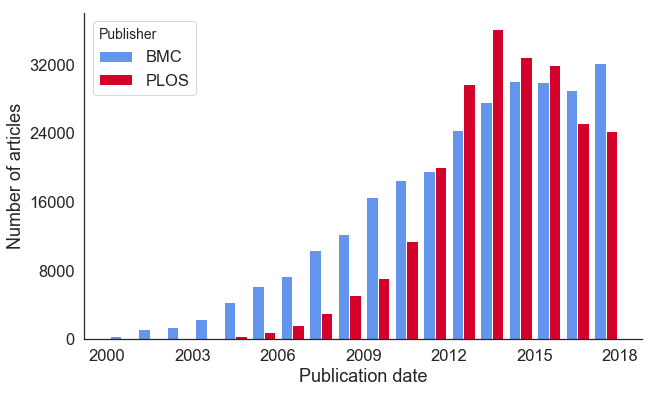

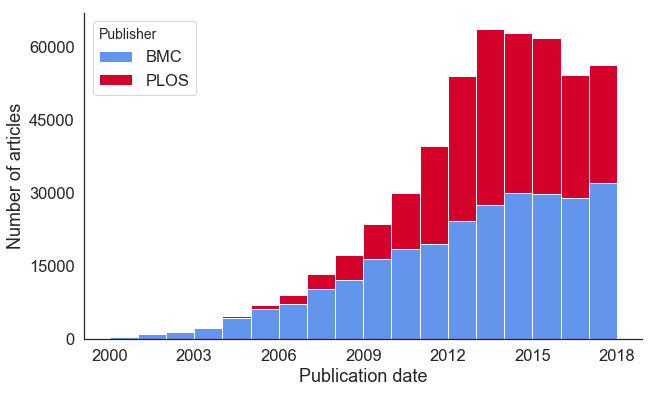

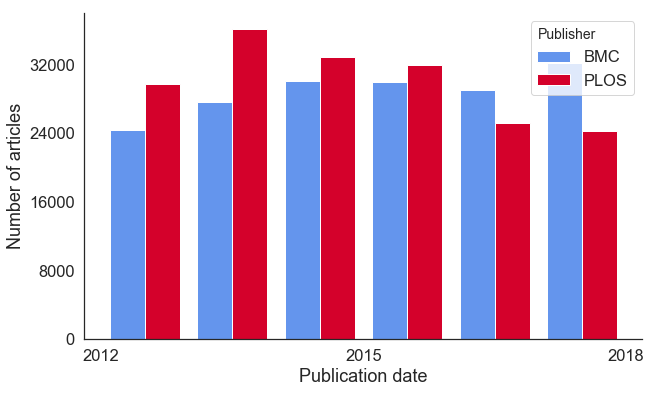

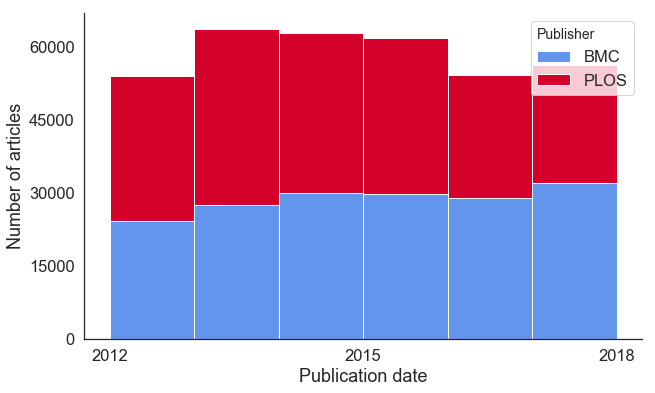

In [12]:
# Stack the data you want to visualise
pub_date_data = [df.loc[df['is_bmc']==True, 'p_date'],
                 df.loc[df['is_plos']==True, 'p_date']]

# Get colors for bmc and plos
color_list = [palette[3], palette[6]]

# Label the data frames
label_list = ['BMC', 'PLOS']

# Legend title
legend_title = 'Publisher'

# Plot the data over two year ranges
year_dict = { 'Dates_2000to2019' : (2000, 2019), 'Dates_2012to2019' : (2012, 2019) }

# As this is all publications there won't be a version with a date line
# as this is different across publications
date_line_str = 'NoDateLine'

# Lets make one stacked and one regular bar histogram
# for all publications between 2000 and 2019 split by publisher
for (year_str, year_range), hist_type in it.product(year_dict.items(), ['bar', 'barstacked']):

    # Name the figure
    output_fname = os.path.join('..',
                                'figures',
                                year_str,
                                date_line_str,
                                hist_type,
                                'PubsOverTime_All_ByPublisher.png')
    
    # Make the figure
    fig, ax = pubs_over_time(pub_date_data,
                             color_list=color_list,
                             label_list=label_list,
                             legend_title=legend_title,
                             year_range=year_range,
                             hist_type=hist_type,
                             output_fname=output_fname)


## 2.0 Show the number of publications with (and without) data availability statements over time

This section makes plots for 3 groups of data:

* BMC articles on their own
* PLOS articles on their own
* PLOS and BMC combined

It makes the plots across two date ranges:

* 2000 to 2019
* 2012 to 20019

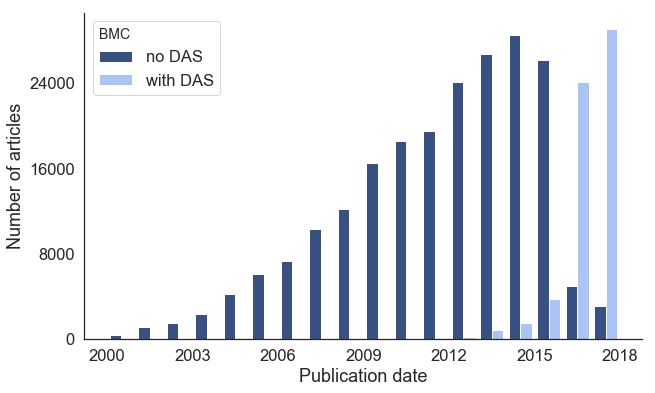

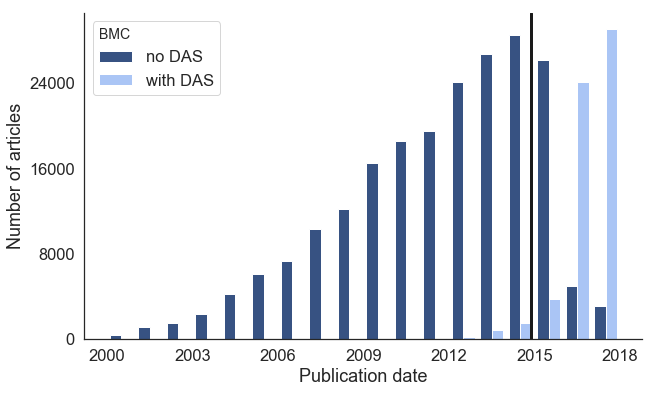

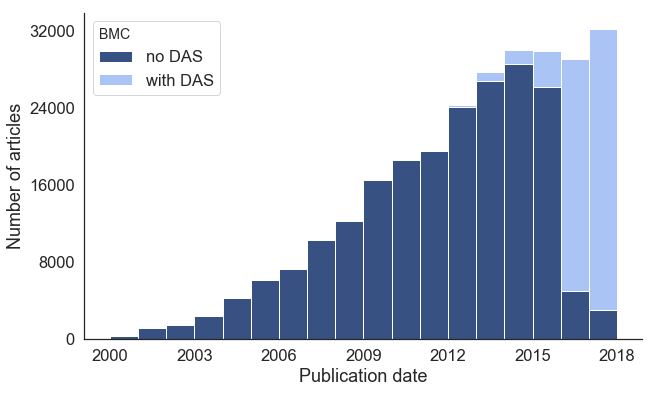

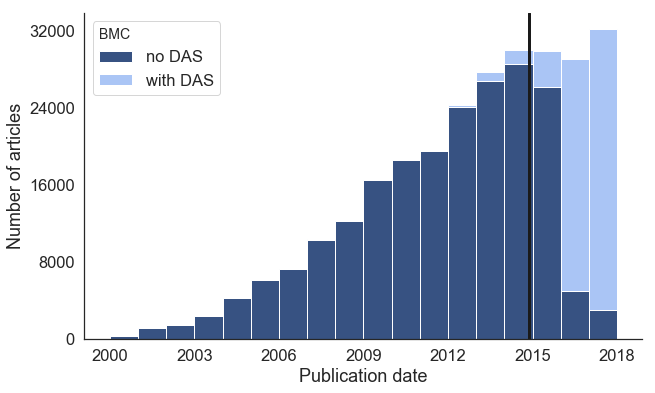

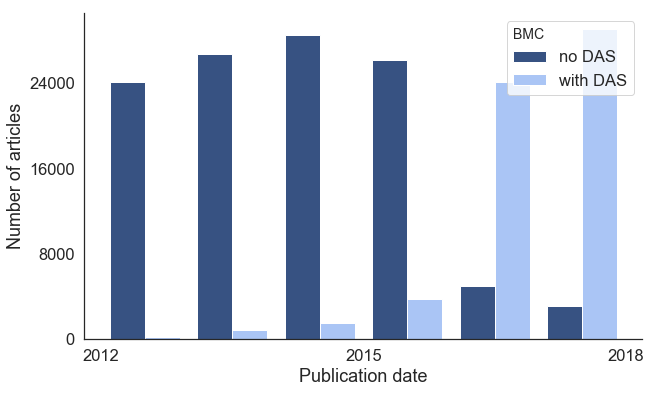

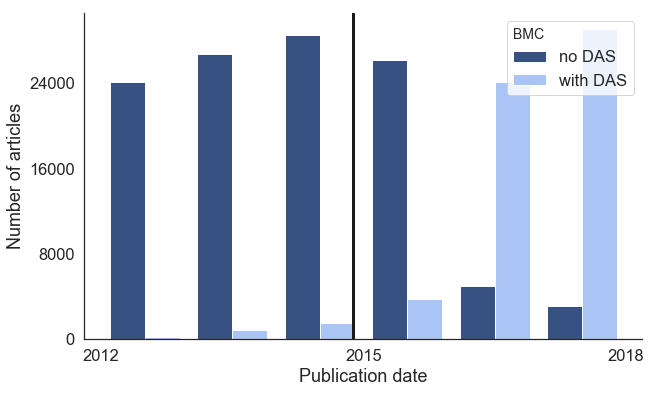

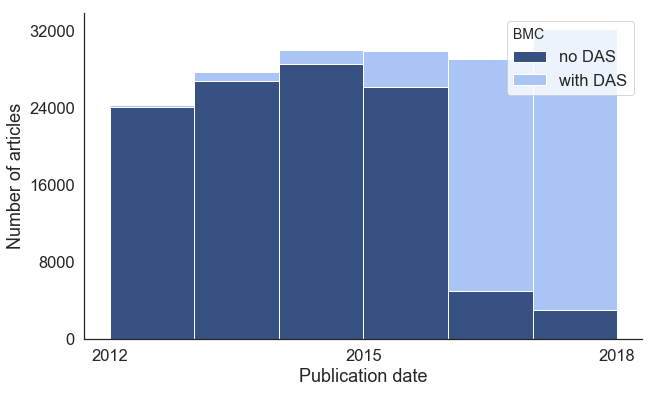

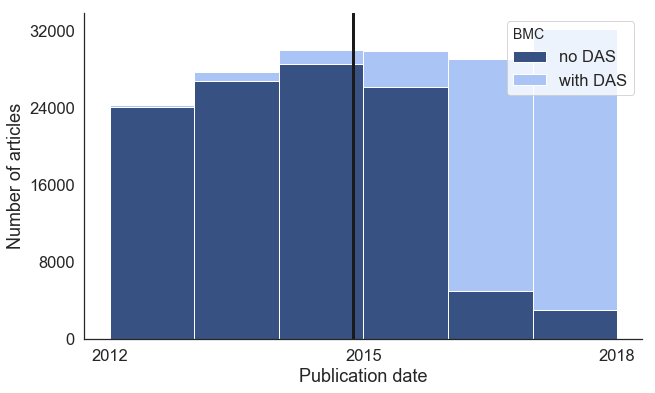

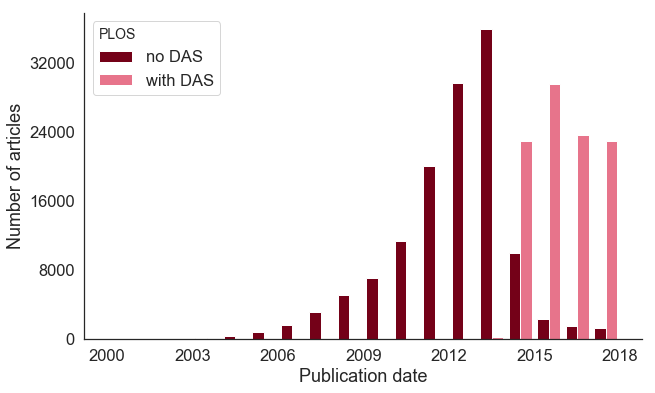

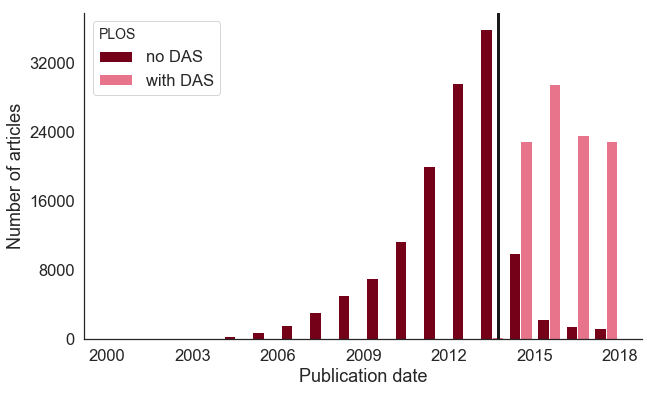

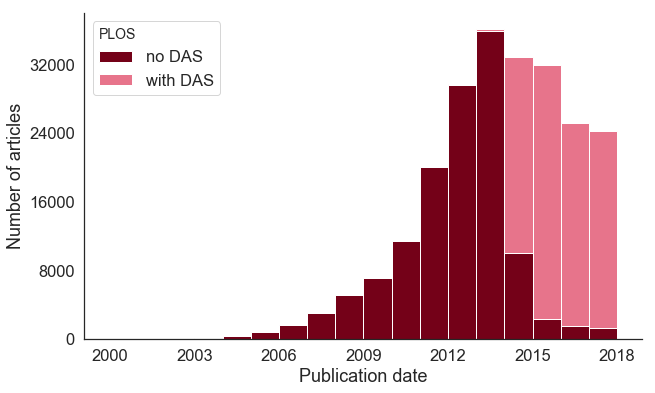

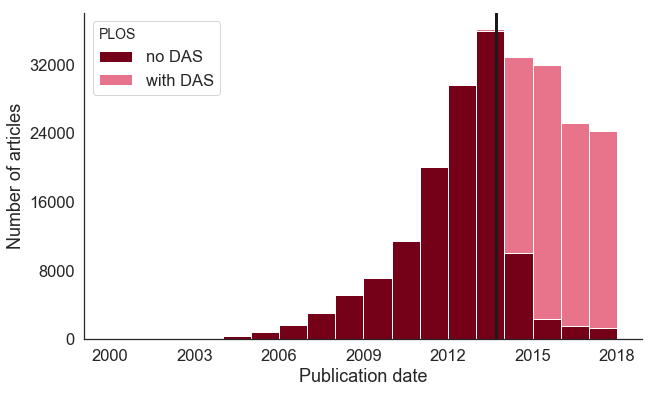

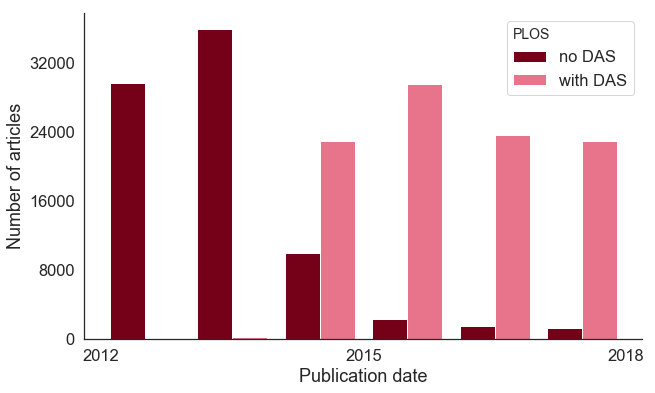

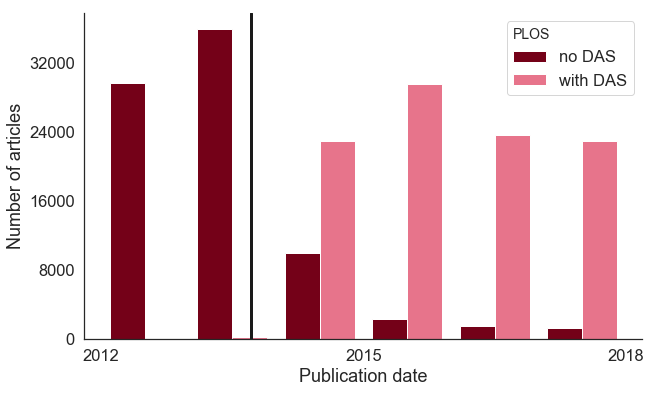

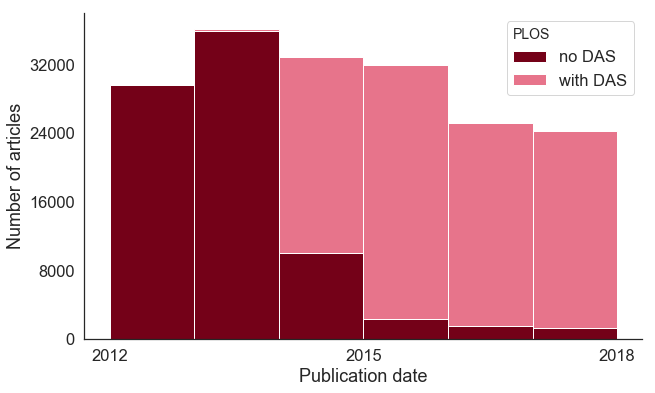

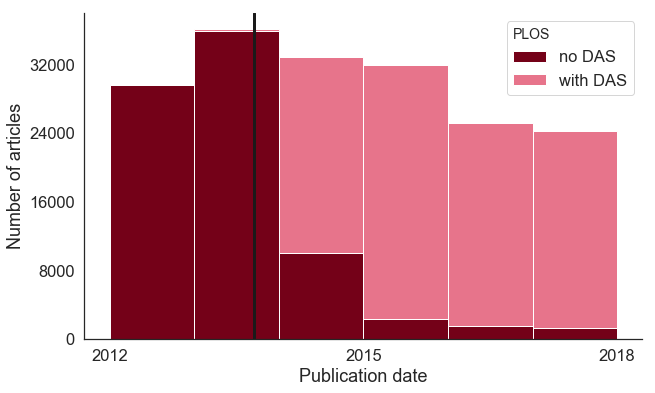

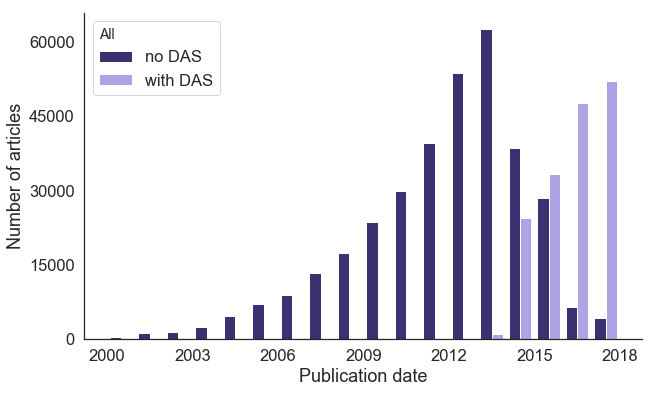

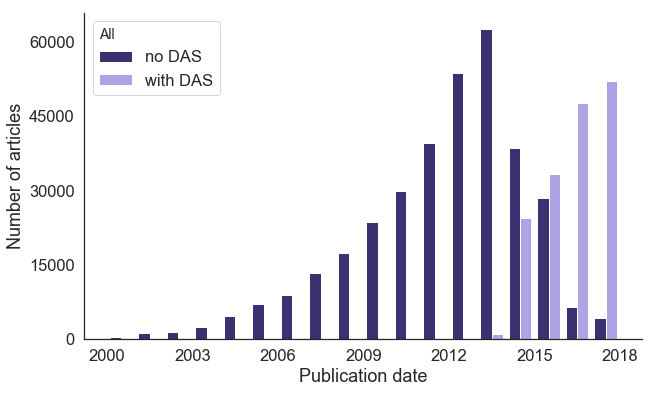

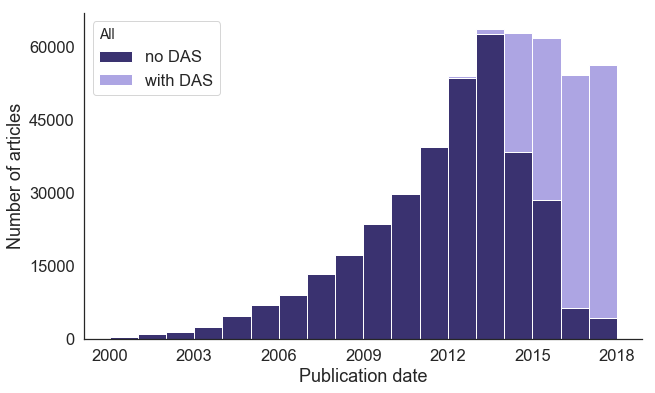

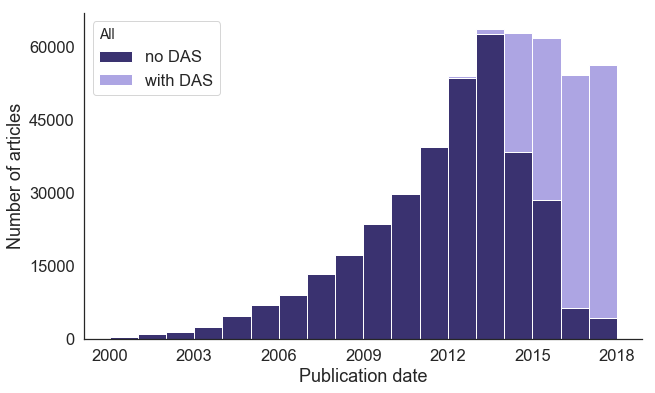

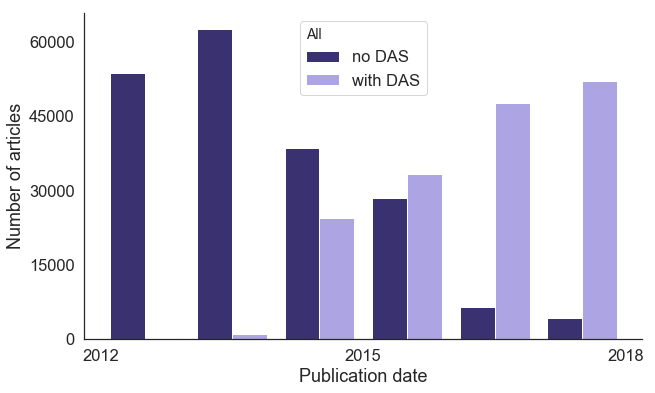

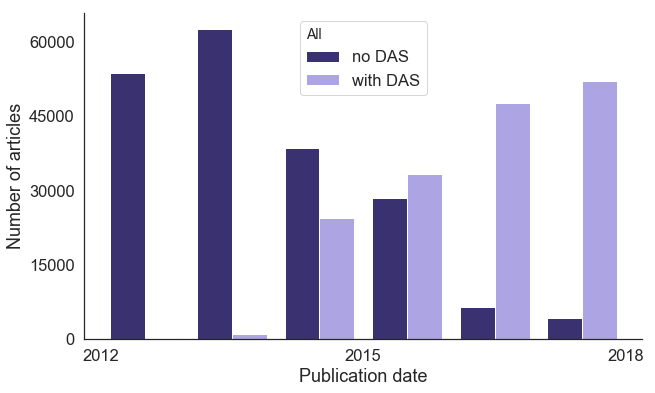

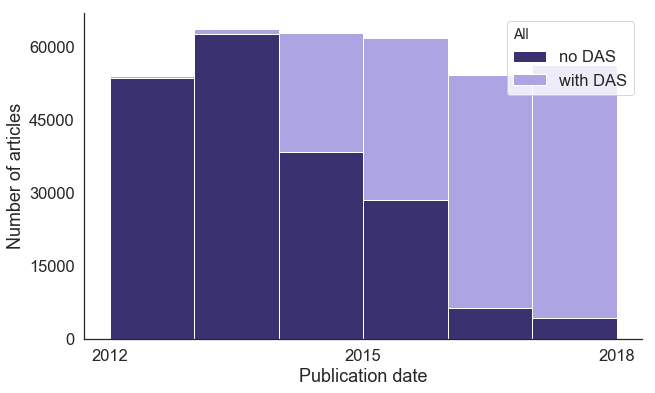

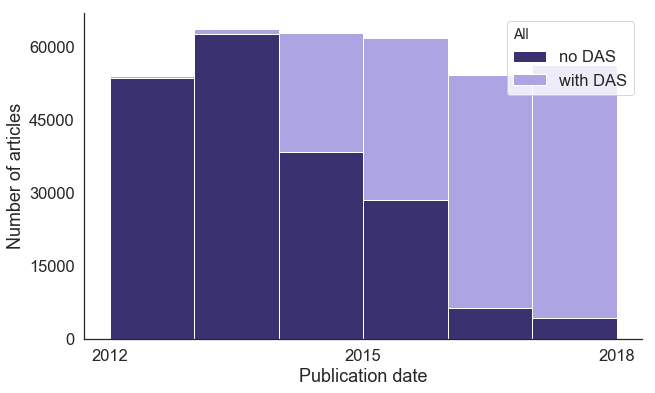

In [13]:
# Define five masks:
# - with and without DAS
das_mask = df['has_das']==True
nodas_mask = df['has_das']==False
# - bmc, plos and combined
bmc_mask = df['is_bmc']==True
plos_mask = df['is_plos']==True
combined_mask = (bmc_mask) | (plos_mask)

# Publisher dictionary
publisher_dict = { 'BMC' : (bmc_mask, 1), 'PLOS' : (plos_mask, 2), 'All' : (combined_mask, 0)}

# Plot the data over two year ranges
year_dict = { 'Dates_2000to2019' : (2000, 2019), 'Dates_2012to2019' : (2012, 2019) }

for ((publisher, (publisher_mask, color_counter)),
     (year_str, year_range)) in it.product(publisher_dict.items(), year_dict.items()):

    # Stack the data you want to visualise
    pub_date_data = [df.loc[(publisher_mask) & (nodas_mask), 'p_date'],
                     df.loc[(publisher_mask) & (das_mask), 'p_date']]

    # Label the data frames
    label_list = [ 'no DAS', 'with DAS']

    # Get the right colours
    color_list = [palette[(color_counter*3) + 2],
                  palette[(color_counter*3) + 1]]

    # Set up the legend
    legend_title = publisher

    # Get the required and encouraged dates
    required_date, encouraged_date = get_mandate_dates(df_policies,
                                                       publisher=publisher,
                                                       journal='All')

    date_line_dict = {'NoDateLine': (None, None),
                      'DateLine' : (required_date, encouraged_date)}
    
    # Lets make one stacked and one regular bar histogram
    # and one version with and one without the datelines
    for (hist_type,
         (date_line_str, (required_date, encouraged_date))) in it.product(['bar', 'barstacked'],
                                                                          date_line_dict.items()):

        output_fname = os.path.join('..',
                                    'figures',
                                    year_str,
                                    date_line_str,
                                    hist_type,
                                    'PubsOverTime_{}_ByDas.png'.format(publisher))

        # Make the figure
        fig, ax = pubs_over_time(pub_date_data,
                                 color_list=color_list,
                                 label_list=label_list,
                                 legend_title=legend_title,
                                 year_range=year_range,
                                 hist_type=hist_type,
                                 output_fname=output_fname,
                                 required_date=required_date,
                                 encouraged_date=encouraged_date)
        plt.show()
        plt.close()

## 3.0 Show the number of publications split by the three DAS classes (and no DAS) over time

This section makes plots for 3 groups of data:

* BMC articles on their own
* PLOS articles on their own
* PLOS and BMC combined

It makes the plots across two date ranges:

* 2000 to 2019
* 2012 to 20019

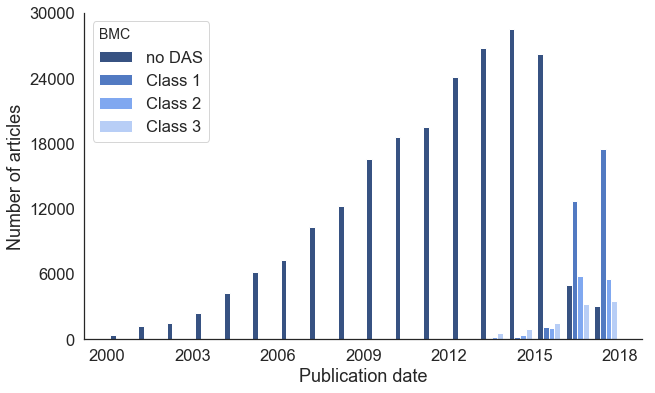

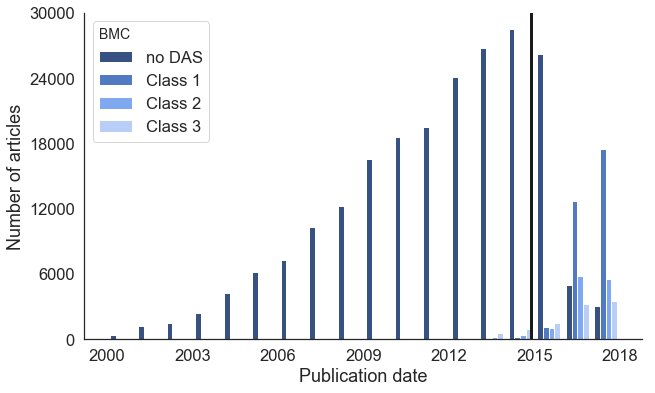

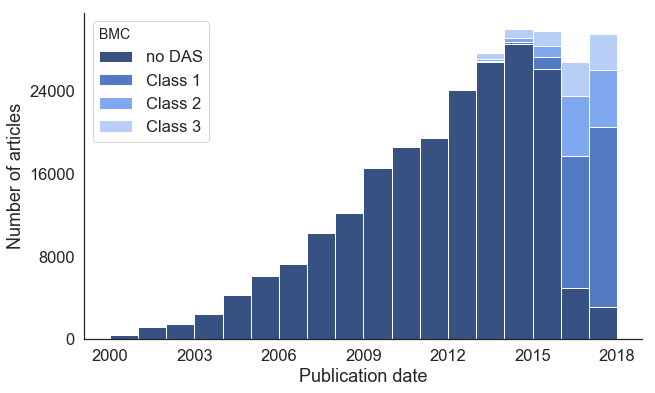

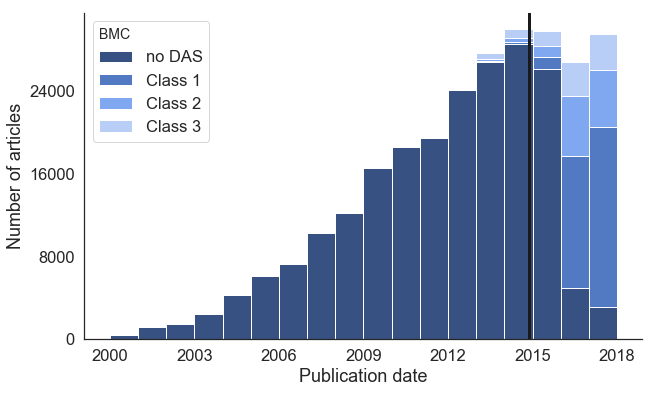

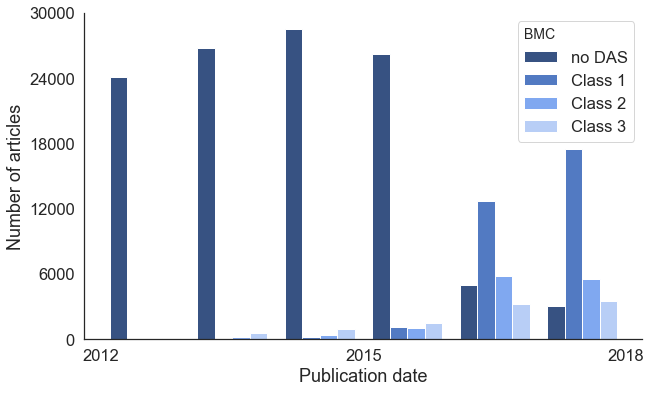

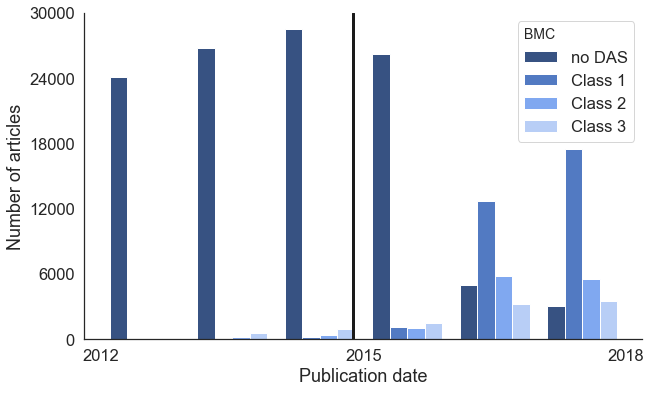

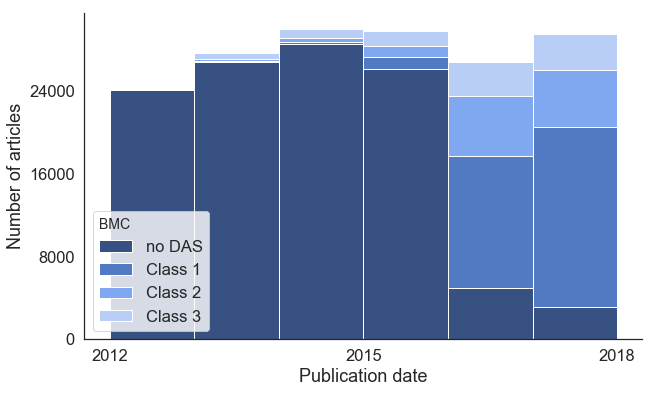

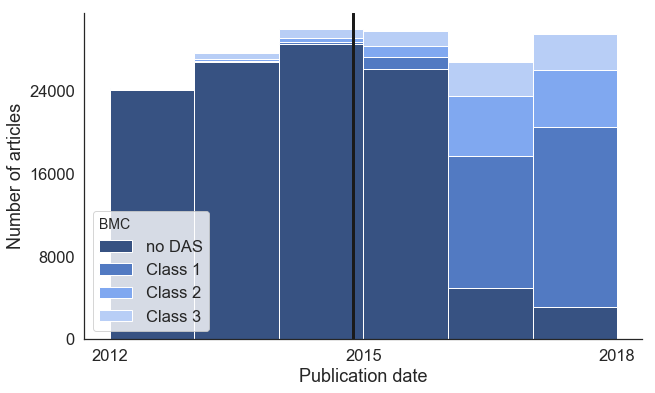

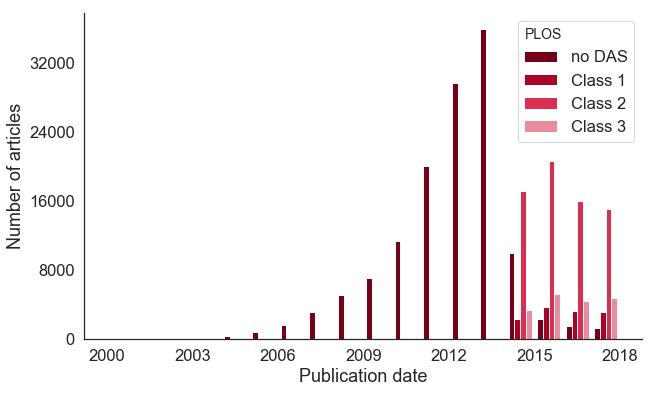

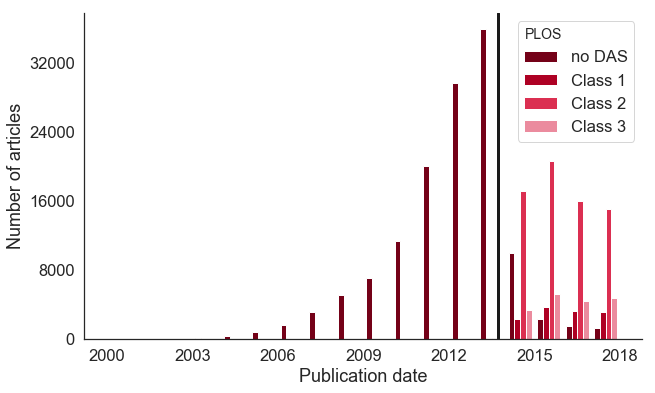

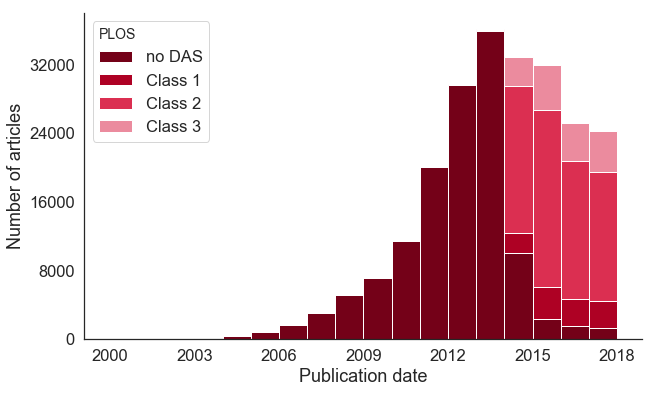

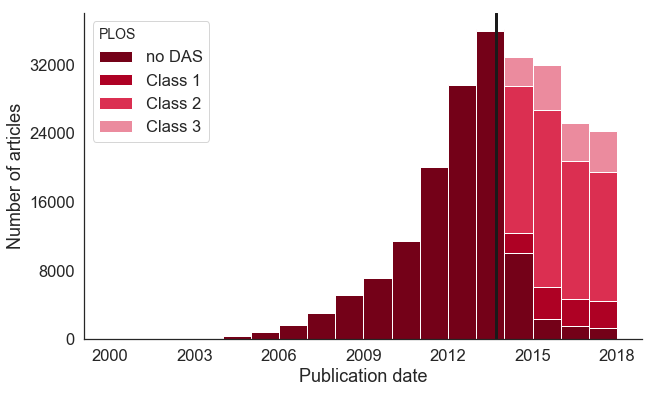

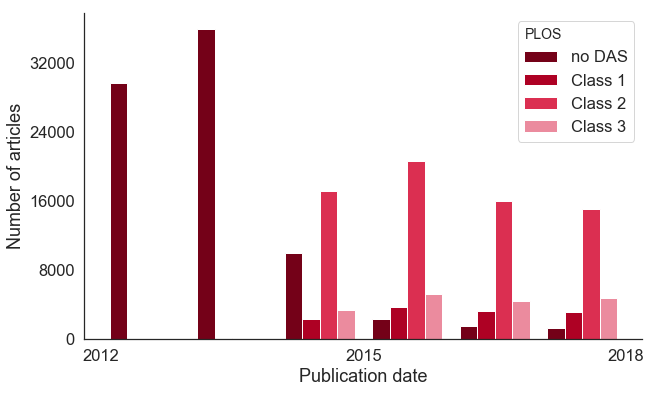

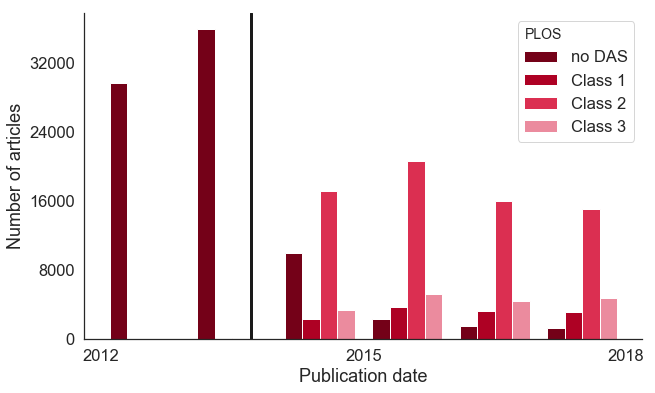

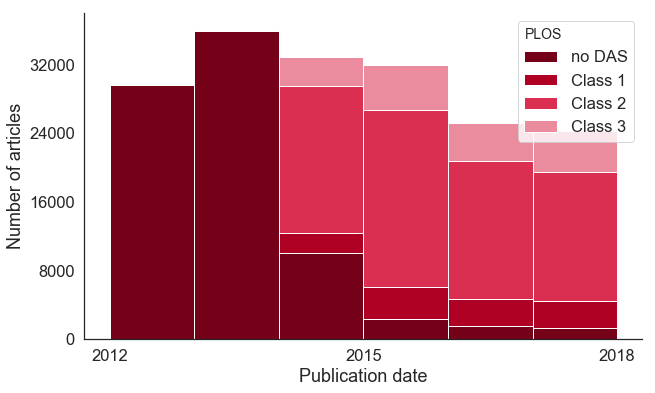

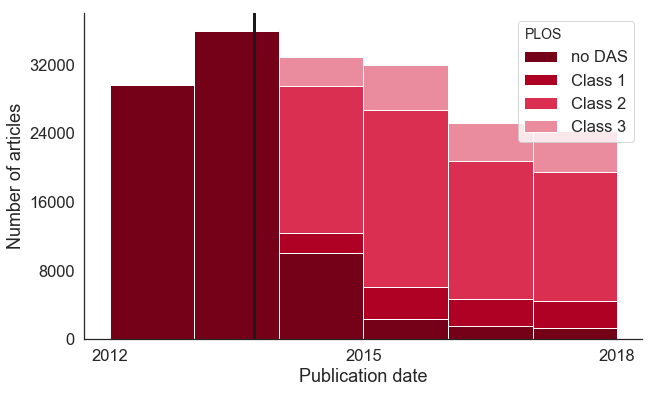

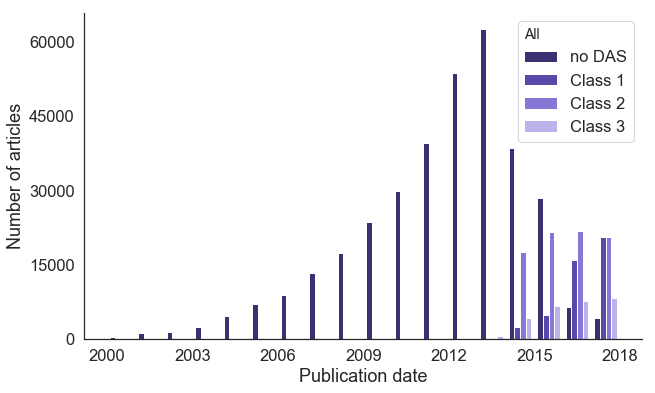

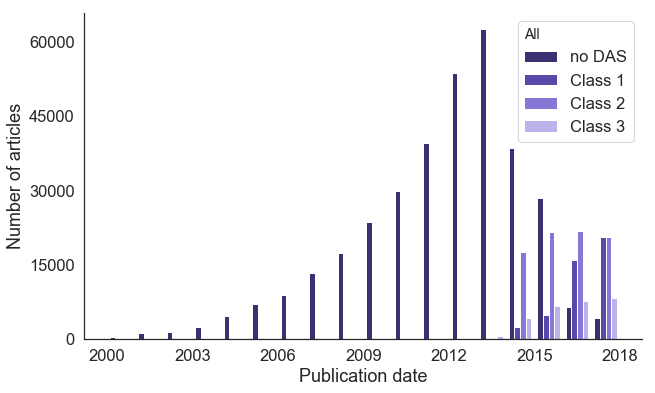

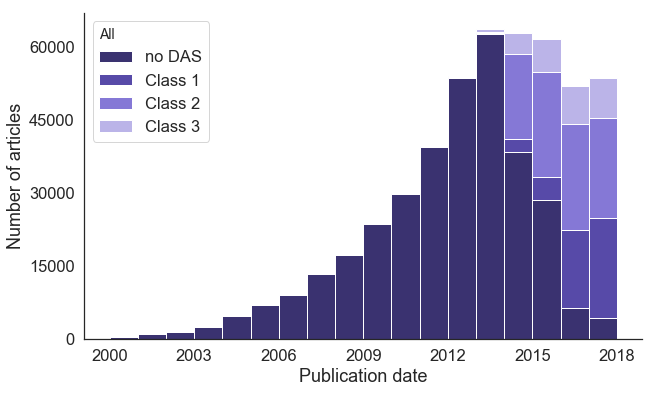

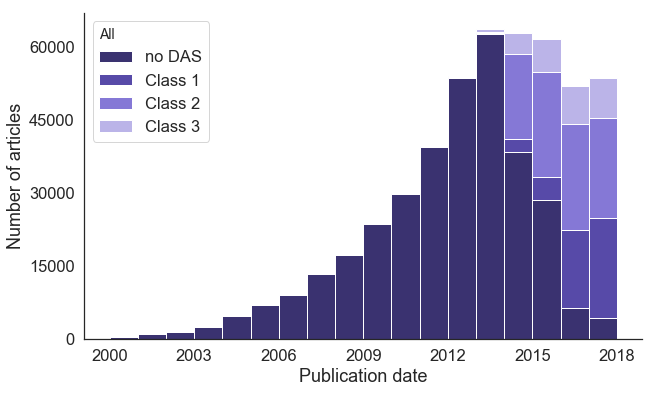

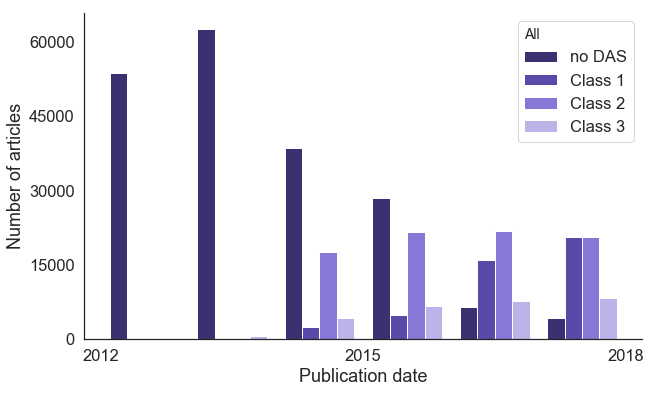

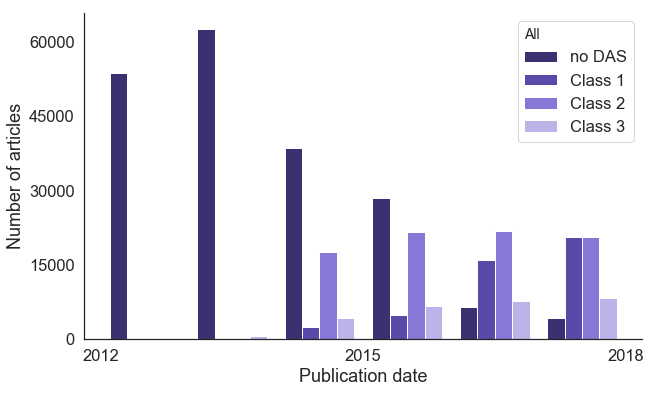

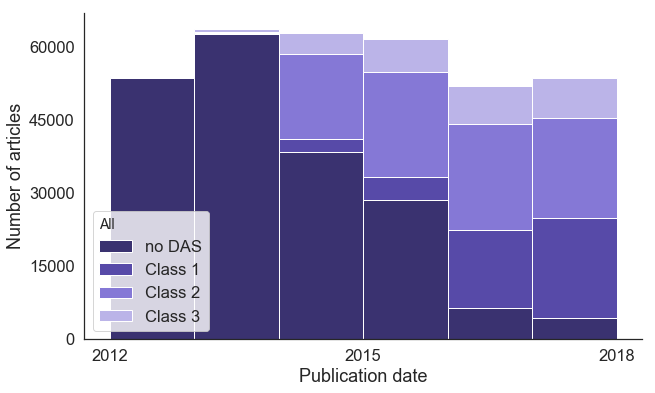

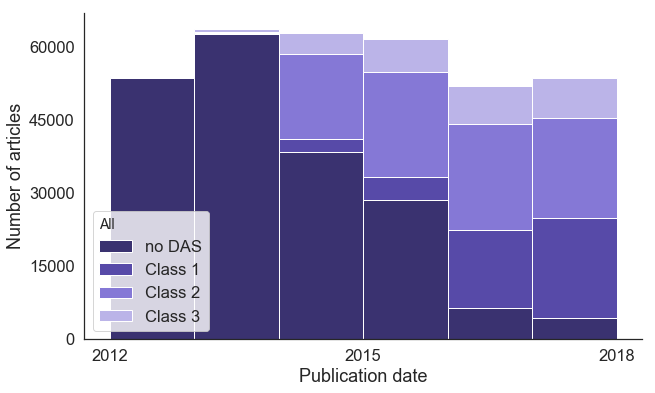

In [14]:
# Define seven masks:
# - the three das classes and no DAS
das1_mask = df['das_class']==1
das2_mask = df['das_class']==2
das3_mask = df['das_class']==3
nodas_mask = df['has_das']==False
# - bmc, plos and combined
bmc_mask = df['is_bmc']==True
plos_mask = df['is_plos']==True
combined_mask = (bmc_mask) | (plos_mask)

# Publisher dictionary
publisher_dict = { 'BMC' : (bmc_mask, 1), 'PLOS' : (plos_mask, 2), 'All' : (combined_mask, 0)}

# Label the data frames

# Plot the data over two year ranges
year_dict = { 'Dates_2000to2019' : (2000, 2019), 'Dates_2012to2019' : (2012, 2019) }

for ((publisher, (publisher_mask, color_counter)),
     (year_str, year_range)) in it.product(publisher_dict.items(), year_dict.items()):

    # Stack the data you want to visualise
    pub_date_data = [df.loc[(publisher_mask) & (nodas_mask), 'p_date'],
                     df.loc[(publisher_mask) & (das1_mask), 'p_date'],
                     df.loc[(publisher_mask) & (das2_mask), 'p_date'],
                     df.loc[(publisher_mask) & (das3_mask), 'p_date']]

    # Label the data frame
    label_list = ['no DAS', 'Class 1', 'Class 2', 'Class 3']

    # Get the right colours
    color_list = [palette_extended[(color_counter*6) + 2],
                  palette_extended[(color_counter*6) + 3],
                  palette_extended[(color_counter*6) + 4],
                  palette_extended[(color_counter*6) + 5]]

    # Set up the legend
    legend_title = publisher

    # Get the required and encouraged dates
    required_date, encouraged_date = get_mandate_dates(df_policies,
                                                       publisher=publisher,
                                                       journal='All')

    date_line_dict = {'NoDateLine': (None, None),
                      'DateLine' : (required_date, encouraged_date)}
    
    # Lets make one stacked and one regular bar histogram
    # and one version with and one without the datelines
    for (hist_type,
         (date_line_str, (required_date, encouraged_date))) in it.product(['bar', 'barstacked'],
                                                                          date_line_dict.items()):

        output_fname = os.path.join('..',
                                    'figures',
                                    year_str,
                                    date_line_str,
                                    hist_type,
                                    'PubsOverTime_{}_ByDas.png'.format(publisher))

        # Make the figure
        fig, ax = pubs_over_time(pub_date_data,
                                 color_list=color_list,
                                 label_list=label_list,
                                 legend_title=legend_title,
                                 year_range=year_range,
                                 hist_type=hist_type,
                                 output_fname=output_fname,
                                 required_date=required_date,
                                 encouraged_date=encouraged_date)
        plt.show()
        plt.close()

## 4 Choose some example journals/collections to illustrate key points

### 4.0 Read in the summary file

Read in the summary csv file that contains the number of articles for each das class within each journal.

In [81]:
df_journal_das = pd.read_csv('../analysis/dataset/journal_das_summary.csv')
df_journal_das.rename(columns={'das_encouraged': 'das_enc', 'das_required' : 'das_req'}, inplace=True)
df_journal_das.head(10)

,j_lower,das_class,N,has_das,das_enc,das_req
0,acta neuropathologica communications,0,489,9,0,264
1,acta neuropathologica communications,1,70,70,0,70
2,acta neuropathologica communications,2,53,53,0,48
3,acta neuropathologica communications,3,21,21,0,18
4,acta veterinaria scandinavica,0,923,5,0,167
5,acta veterinaria scandinavica,1,116,116,0,114
6,acta veterinaria scandinavica,2,19,19,0,19
7,acta veterinaria scandinavica,3,3,3,0,3
8,addiction science & clinical practice,0,183,8,0,79
9,addiction science & clinical practice,1,34,34,0,34


### 4.1 Reshape the file into wide format

In [82]:
df_journal_das = df_journal_das.set_index(['j_lower', 'das_class']).unstack()
df_journal_das.columns = df_journal_das.columns.map('{0[0]}-{0[1]}'.format)

### 4.2 Add a few useful columns

In [88]:
# Add a total column
df_journal_das['N-tot'] = df_journal_das.loc[:, ['N-0', 'N-1', 'N-2', 'N-3']].sum(axis=1)

# Make a couple of sum columns
df_journal_das['das_enc-tot'] = df_journal_das.loc[:, ['das_enc-1', 'das_enc-2', 'das_enc-3']].sum(axis=1)
df_journal_das['das_req-tot'] = df_journal_das.loc[:, ['das_req-1', 'das_req-2', 'das_req-3']].sum(axis=1)

# Make some proportional columns
for das_class in list(range(4)) + ['tot']:
    df_journal_das['das_enc_prop-{}'.format(das_class)] = df_journal_das['das_enc-{}'.format(das_class)]*1.0/df_journal_das['N-tot']
    df_journal_das['das_req_prop-{}'.format(das_class)] = df_journal_das['das_req-{}'.format(das_class)]*1.0/df_journal_das['N-tot']

df_journal_das = df_journal_das.reindex(sorted(df_journal_das.columns), axis=1)

In [89]:
pd.set_option('display.max_columns', 500)
df_journal_das.head(10)

,N-0,N-1,N-2,N-3,N-tot,das_enc-0,das_enc-1,das_enc-2,das_enc-3,das_enc-tot,das_enc_prop-0,das_enc_prop-1,das_enc_prop-2,das_enc_prop-3,das_enc_prop-tot,das_req-0,das_req-1,das_req-2,das_req-3,das_req-tot,das_req_prop-0,das_req_prop-1,das_req_prop-2,das_req_prop-3,das_req_prop-tot,has_das-0,has_das-1,has_das-2,has_das-3
j_lower,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
acta neuropathologica communications,489.0,70.0,53.0,21.0,633.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,264.0,70.0,48.0,18.0,136.0,0.417062,0.110585,0.075829,0.028436,0.214850,9.0,70.0,53.0,21.0
acta veterinaria scandinavica,923.0,116.0,19.0,3.0,1061.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,167.0,114.0,19.0,3.0,136.0,0.157399,0.107446,0.017908,0.002828,0.128181,5.0,116.0,19.0,3.0
addiction science & clinical practice,183.0,34.0,1.0,1.0,219.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,79.0,34.0,1.0,1.0,36.0,0.360731,0.155251,0.004566,0.004566,0.164384,8.0,34.0,1.0,1.0
advances in simulation,36.0,31.0,4.0,2.0,73.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,36.0,31.0,4.0,2.0,37.0,0.493151,0.424658,0.054795,0.027397,0.506849,13.0,31.0,4.0,2.0
aids research and therapy,364.0,59.0,4.0,5.0,432.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,53.0,58.0,4.0,5.0,67.0,0.122685,0.134259,0.009259,0.011574,0.155093,1.0,59.0,4.0,5.0
algorithms for molecular biology,300.0,7.0,4.0,17.0,328.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,60.0,6.0,4.0,17.0,27.0,0.182927,0.018293,0.012195,0.051829,0.082317,6.0,7.0,4.0,17.0
"allergy, asthma, and clinical immunology : official journal of the canadian society of allergy and clinical immunology",349.0,83.0,20.0,3.0,455.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,72.0,83.0,19.0,3.0,105.0,0.158242,0.182418,0.041758,0.006593,0.230769,17.0,83.0,20.0,3.0
alzheimer's research & therapy,277.0,168.0,11.0,10.0,466.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,106.0,168.0,11.0,10.0,189.0,0.227468,0.360515,0.023605,0.021459,0.405579,24.0,168.0,11.0,10.0
annals of clinical microbiology and antimicrobials,444.0,54.0,54.0,10.0,562.0,136.0,2.0,10.0,0.0,12.0,0.241993,0.003559,0.017794,0.0,0.021352,81.0,52.0,44.0,10.0,106.0,0.144128,0.092527,0.078292,0.017794,0.188612,10.0,54.0,54.0,10.0


### 4.3 Take a look at some of the largest journals

* BMC Public Health: 12234 articles
* BMC Genomics: 11591 articles
* BMC Cancer: 9307 articles

In [90]:
df_journal_das.sort_values(by='N-tot', ascending=False).head()

,N-0,N-1,N-2,N-3,N-tot,das_enc-0,das_enc-1,das_enc-2,das_enc-3,das_enc-tot,das_enc_prop-0,das_enc_prop-1,das_enc_prop-2,das_enc_prop-3,das_enc_prop-tot,das_req-0,das_req-1,das_req-2,das_req-3,das_req-tot,das_req_prop-0,das_req_prop-1,das_req_prop-2,das_req_prop-3,das_req_prop-tot,has_das-0,has_das-1,has_das-2,has_das-3
j_lower,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bmc public health,9309.0,2487.0,251.0,187.0,12234.0,2966.0,15.0,1.0,1.0,17.0,0.242439,0.001226,0.000082,0.000082,0.001390,1513.0,2460.0,249.0,185.0,2894.0,0.123672,0.201079,0.020353,0.015122,0.236554,229.0,2487.0,251.0,187.0
bmc genomics,7530.0,417.0,760.0,2884.0,11591.0,1883.0,34.0,160.0,686.0,880.0,0.162454,0.002933,0.013804,0.059184,0.075921,728.0,371.0,598.0,2148.0,3117.0,0.062807,0.032008,0.051592,0.185316,0.268916,34.0,417.0,760.0,2884.0
bmc cancer,6737.0,1706.0,676.0,188.0,9307.0,1925.0,1.0,1.0,8.0,10.0,0.206834,0.000107,0.000107,0.000860,0.001074,1231.0,1705.0,675.0,179.0,2559.0,0.132266,0.183195,0.072526,0.019233,0.274954,171.0,1706.0,676.0,188.0
critical care,8533.0,323.0,74.0,16.0,8946.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,677.0,323.0,74.0,16.0,413.0,0.075676,0.036106,0.008272,0.001789,0.046166,142.0,323.0,74.0,16.0
bmc bioinformatics,7417.0,459.0,247.0,791.0,8914.0,1300.0,29.0,29.0,43.0,101.0,0.145838,0.003253,0.003253,0.004824,0.011330,688.0,407.0,213.0,737.0,1357.0,0.077182,0.045659,0.023895,0.082679,0.152232,45.0,459.0,247.0,791.0


### 4.4 Take a look at big journals that have high proportions of _encouraged_ das



In [98]:
df_journal_das.loc[df_journal_das['N-tot']>2000].sort_values(by='das_enc_prop-tot', ascending=False).head(10)

,N-0,N-1,N-2,N-3,N-tot,das_enc-0,das_enc-1,das_enc-2,das_enc-3,das_enc-tot,das_enc_prop-0,das_enc_prop-1,das_enc_prop-2,das_enc_prop-3,das_enc_prop-tot,das_req-0,das_req-1,das_req-2,das_req-3,das_req-tot,das_req_prop-0,das_req_prop-1,das_req_prop-2,das_req_prop-3,das_req_prop-tot,has_das-0,has_das-1,has_das-2,has_das-3
j_lower,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bmc genomics,7530.0,417.0,760.0,2884.0,11591.0,1883.0,34.0,160.0,686.0,880.0,0.162454,0.002933,0.013804,0.059184,0.075921,728.0,371.0,598.0,2148.0,3117.0,0.062807,0.032008,0.051592,0.185316,0.268916,34.0,417.0,760.0,2884.0
bmc evolutionary biology,2716.0,108.0,286.0,714.0,3824.0,347.0,7.0,56.0,213.0,276.0,0.090743,0.001831,0.014644,0.055701,0.072176,141.0,99.0,229.0,493.0,821.0,0.036872,0.025889,0.059885,0.128923,0.214697,4.0,108.0,286.0,714.0
bmc plant biology,1832.0,229.0,425.0,527.0,3013.0,506.0,5.0,81.0,124.0,210.0,0.167939,0.001659,0.026884,0.041155,0.069698,128.0,223.0,344.0,400.0,967.0,0.042483,0.074013,0.114172,0.132758,0.320943,7.0,229.0,425.0,527.0
bmc research notes,4500.0,1144.0,619.0,289.0,6552.0,2178.0,40.0,82.0,80.0,202.0,0.332418,0.006105,0.012515,0.012210,0.030830,1012.0,1100.0,532.0,203.0,1835.0,0.154457,0.167888,0.081197,0.030983,0.280067,71.0,1144.0,619.0,289.0
bmc microbiology,2783.0,211.0,245.0,293.0,3532.0,662.0,2.0,19.0,41.0,62.0,0.187429,0.000566,0.005379,0.011608,0.017554,249.0,208.0,226.0,251.0,685.0,0.070498,0.058890,0.063986,0.071065,0.193941,6.0,211.0,245.0,293.0
bmc bioinformatics,7417.0,459.0,247.0,791.0,8914.0,1300.0,29.0,29.0,43.0,101.0,0.145838,0.003253,0.003253,0.004824,0.011330,688.0,407.0,213.0,737.0,1357.0,0.077182,0.045659,0.023895,0.082679,0.152232,45.0,459.0,247.0,791.0
bmc veterinary research,1540.0,567.0,322.0,114.0,2543.0,649.0,5.0,13.0,10.0,28.0,0.255210,0.001966,0.005112,0.003932,0.011011,322.0,562.0,309.0,104.0,975.0,0.126622,0.220999,0.121510,0.040897,0.383405,15.0,567.0,322.0,114.0
bmc pediatrics,1605.0,549.0,103.0,23.0,2280.0,556.0,6.0,1.0,1.0,8.0,0.243860,0.002632,0.000439,0.000439,0.003509,317.0,542.0,102.0,22.0,666.0,0.139035,0.237719,0.044737,0.009649,0.292105,33.0,549.0,103.0,23.0
bmc infectious diseases,4301.0,1323.0,451.0,153.0,6228.0,1543.0,2.0,2.0,5.0,9.0,0.247752,0.000321,0.000321,0.000803,0.001445,674.0,1320.0,449.0,148.0,1917.0,0.108221,0.211946,0.072094,0.023764,0.307803,105.0,1323.0,451.0,153.0


In [111]:
df_journal_das.loc[df_journal_das['N-tot']>2000].sort_values(by='das_req-2', ascending=False).head(10)

,N-0,N-1,N-2,N-3,N-tot,das_enc-0,das_enc-1,das_enc-2,das_enc-3,das_enc-tot,das_enc_prop-0,das_enc_prop-1,das_enc_prop-2,das_enc_prop-3,das_enc_prop-tot,das_req-0,das_req-1,das_req-2,das_req-3,das_req-tot,das_req_prop-0,das_req_prop-1,das_req_prop-2,das_req_prop-3,das_req_prop-tot,has_das-0,has_das-1,has_das-2,has_das-3
j_lower,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bmc cancer,6737.0,1706.0,676.0,188.0,9307.0,1925.0,1.0,1.0,8.0,10.0,0.206834,0.000107,0.000107,0.000860,0.001074,1231.0,1705.0,675.0,179.0,2559.0,0.132266,0.183195,0.072526,0.019233,0.274954,171.0,1706.0,676.0,188.0
parasites & vectors,2555.0,425.0,600.0,412.0,3992.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,756.0,425.0,600.0,411.0,1436.0,0.189379,0.106463,0.150301,0.102956,0.359719,47.0,425.0,600.0,412.0
bmc genomics,7530.0,417.0,760.0,2884.0,11591.0,1883.0,34.0,160.0,686.0,880.0,0.162454,0.002933,0.013804,0.059184,0.075921,728.0,371.0,598.0,2148.0,3117.0,0.062807,0.032008,0.051592,0.185316,0.268916,34.0,417.0,760.0,2884.0
bmc complementary and alternative medicine,2261.0,605.0,566.0,43.0,3475.0,1012.0,0.0,0.0,1.0,1.0,0.291223,0.000000,0.000000,0.000288,0.000288,487.0,605.0,566.0,42.0,1213.0,0.140144,0.174101,0.162878,0.012086,0.349065,27.0,605.0,566.0,43.0
bmc research notes,4500.0,1144.0,619.0,289.0,6552.0,2178.0,40.0,82.0,80.0,202.0,0.332418,0.006105,0.012515,0.012210,0.030830,1012.0,1100.0,532.0,203.0,1835.0,0.154457,0.167888,0.081197,0.030983,0.280067,71.0,1144.0,619.0,289.0
bmc infectious diseases,4301.0,1323.0,451.0,153.0,6228.0,1543.0,2.0,2.0,5.0,9.0,0.247752,0.000321,0.000321,0.000803,0.001445,674.0,1320.0,449.0,148.0,1917.0,0.108221,0.211946,0.072094,0.023764,0.307803,105.0,1323.0,451.0,153.0
bmc plant biology,1832.0,229.0,425.0,527.0,3013.0,506.0,5.0,81.0,124.0,210.0,0.167939,0.001659,0.026884,0.041155,0.069698,128.0,223.0,344.0,400.0,967.0,0.042483,0.074013,0.114172,0.132758,0.320943,7.0,229.0,425.0,527.0
bmc veterinary research,1540.0,567.0,322.0,114.0,2543.0,649.0,5.0,13.0,10.0,28.0,0.255210,0.001966,0.005112,0.003932,0.011011,322.0,562.0,309.0,104.0,975.0,0.126622,0.220999,0.121510,0.040897,0.383405,15.0,567.0,322.0,114.0
journal of neuroinflammation,1496.0,405.0,255.0,28.0,2184.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,336.0,405.0,255.0,28.0,688.0,0.153846,0.185440,0.116758,0.012821,0.315018,51.0,405.0,255.0,28.0


### 4.6 Now that we've made our decisions, make the plots

This section makes plots for the following specific journals or collections of publications:

* BMC series articles
* PLOS one articles
* PLOS "not one" articles
* BMC Genomics -- good adoption of class 3 in encouraged phase
* BMC Health Services Research -- lots and lots of class 1
* Trials -- lots and lots of class 1
* Parasites & Vectors

It makes the plots across two date ranges:

* 2000 to 2019
* 2012 to 20019

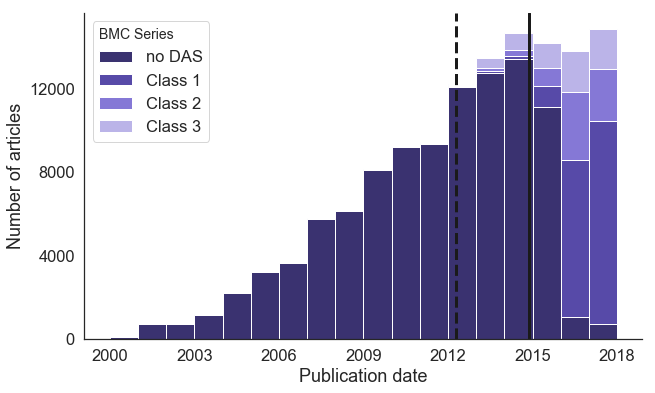

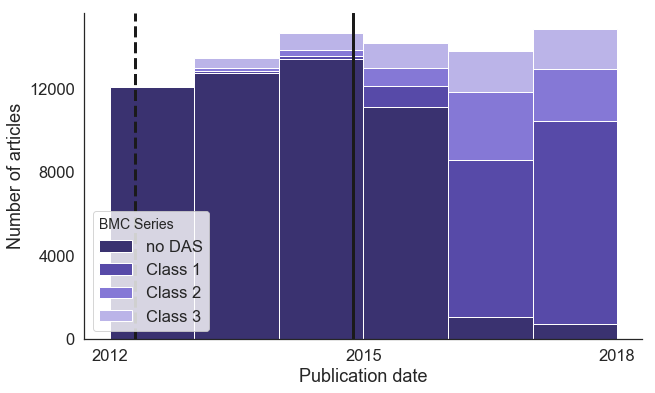

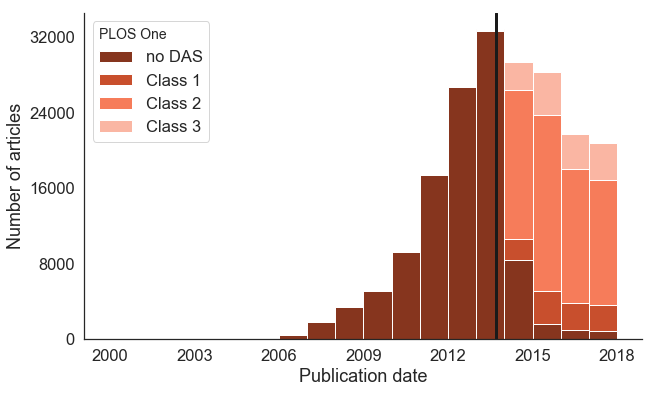

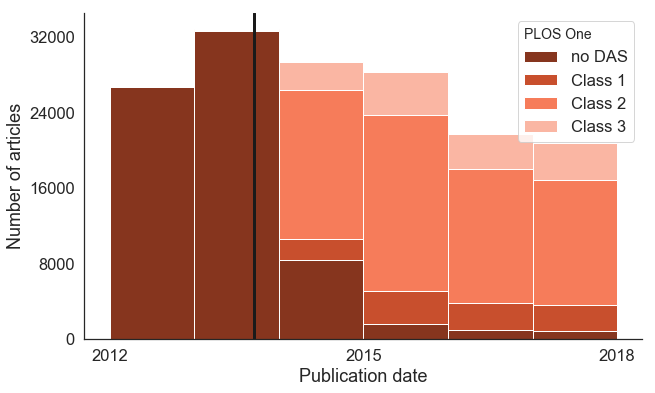

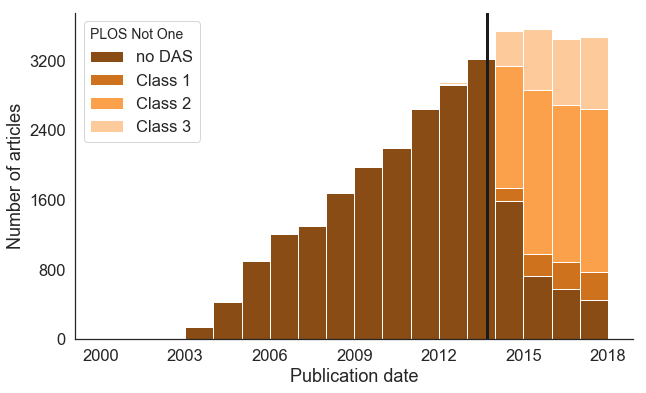

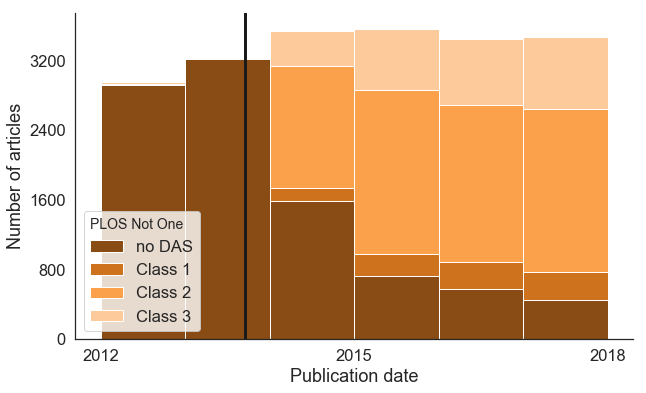

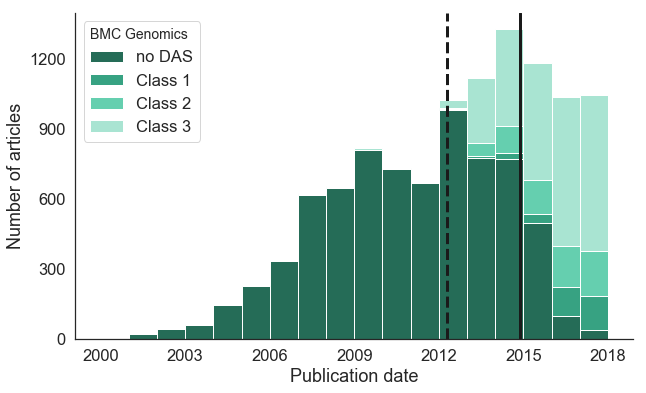

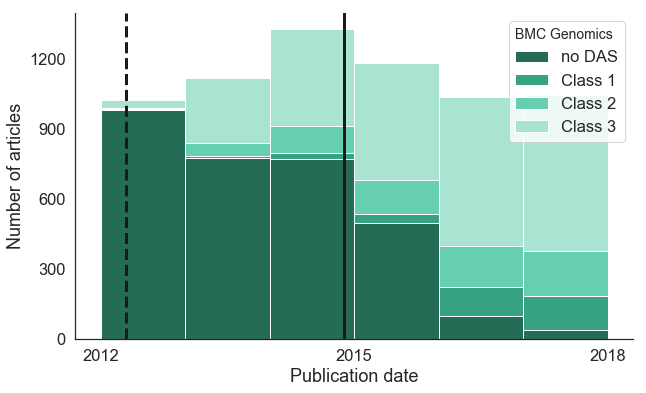

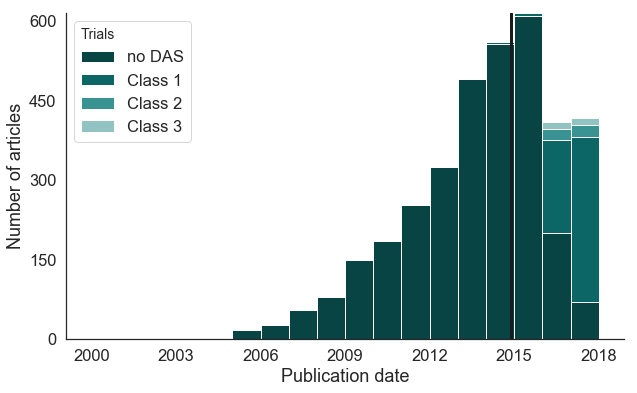

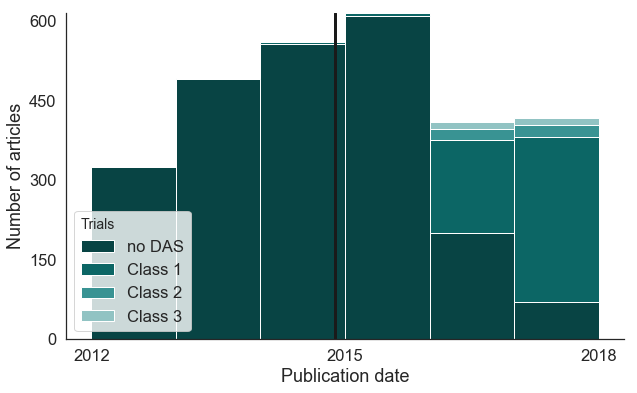

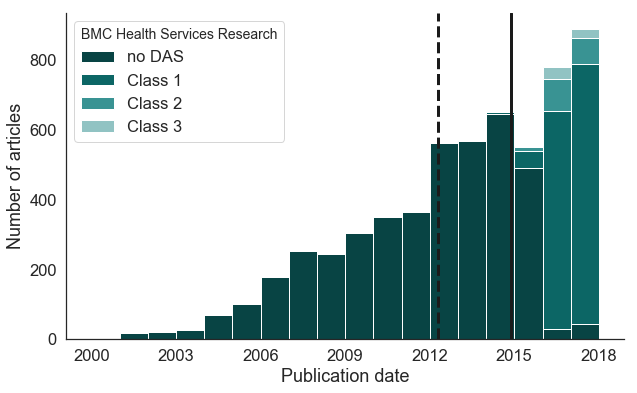

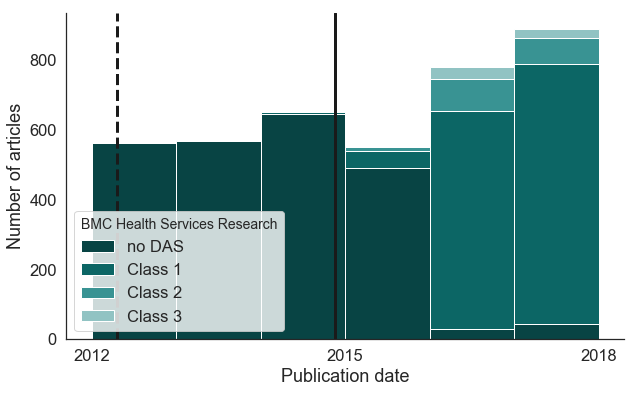

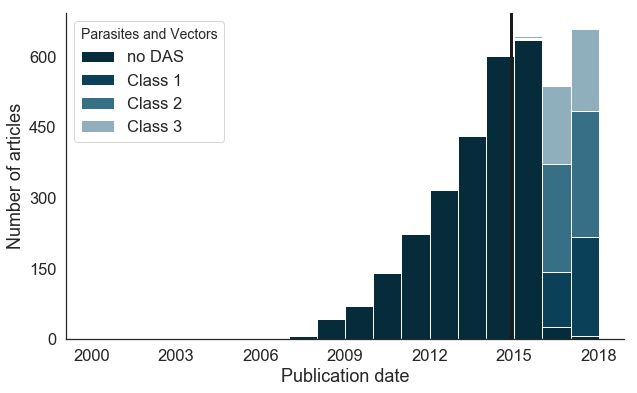

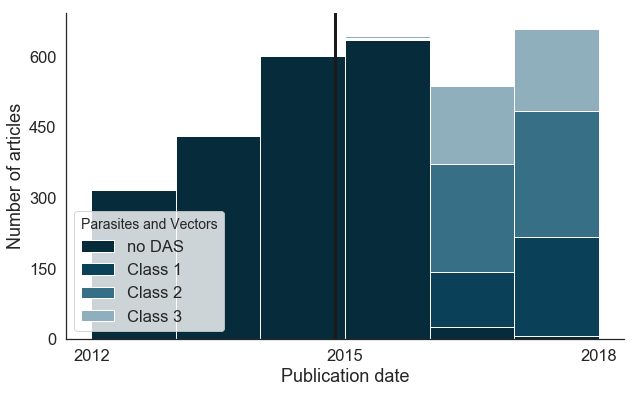

In [129]:
publisher_journal_dict = { 'BMC Series' : ('BMC Series', 'All', bmc_series_mask, 0),
                           'PLOS One' : ('PLOS', 'PLOS One', plos_one_mask, 3),
                           'PLOS Not One' : ('PLOS', 'All', plos_notone_mask, 4),
                           'BMC Genomics' : ('BMC Series', 'All', df['j_lower'] == 'bmc genomics', 6),
                           'Trials' : ('BMC', 'Trials', df['j_lower'] == 'trials', 7),
                           'BMC Health Services Research' : ('BMC Series', 'All', df['j_lower'] == 'bmc health services research', 7),
                           'Parasites and Vectors' : ('BMC', 'All', df['j_lower'] == 'parasites & vectors', 8)
                          }

make_lots_of_plots(df, publisher_journal_dict, palette_extended, df_policies)

In [128]:
for article_selection_label, (publisher_name, journal_name, article_selection_mask, color_counter) in publisher_journal_dict.items():
    
    print ('======= ARTICLES FROM {} ========='.format(article_selection_label.upper()))
    for das_class in range(1,4):
        print ('DAS CLASS {}\n'.format(das_class))
        for title, das in df.loc[(df['das_class']==das_class) & (article_selection_mask), ['title', 'das']].sample(n=3).values:
            print ('  TITLE: {}'.format(title))
            print ('  DAS: {}'.format(das))
            print ("  -------")
        print ("\n============")

======= ARTICLES FROM BMC PSYCHOLOGY =========
DAS CLASS 1

  TITLE: A blended psychosocial support program for partners of patients with amyotrophic lateral sclerosis and progressive muscular atrophy: protocol of a randomized controlled trial
  DAS: The datasets generated and analyzed during the current study will be available from the author upon reasonable request.
  -------
  TITLE: Exploring the reliability and acceptability of cognitive tests for Indigenous Australians: a pilot study
  DAS: The datasets generated during and/or analysed during the current study are not publicly available due to the initial conditions agreed upon in the ethics application but are available from the corresponding author on reasonable request.
  -------
  TITLE: Prevalence and psychometric screening for the detection of major depressive disorder and post-traumatic stress disorder in adults injured in a motor vehicle crash who are engaged in compensation
  DAS: Given that this is an ongoing prospectiv

In [120]:
df.loc[(df['das_class']==das_class) & (article_selection_mask), ['title', 'das']].sample(n=3).values

array([[ 'Views on a brief mindfulness intervention among patients with long-term illness',
        'The data will not be made publically available in order to protect participant identity but is available upon request to Ana Howarth (p1306542@sgul.ac.uk).'],
       [ 'Multi-type child maltreatment: prevalence and its relationship with self-esteem among secondary school students in Tanzania',
        'The datasets used and analysed during the current study are available from the corresponding author on reasonable request.'],
       [ 'The CogBIAS longitudinal study protocol: cognitive and genetic factors influencing psychological functioning in adolescence',
        'Data collection for the study is still on-going. The authors will aim to publish data-sets along with any research findings that are published, in order to support open science. Data that is collected will also be available to share with other researchers upon reasonable request to the first or last author.']], dtype=objec

This section makes plots for the following specific journals or collections of publications:

* BMC series articles
* PLOS one articles
* PLOS "not one" articles

It makes the plots across two date ranges:

* 2000 to 2019
* 2012 to 20019

We've picked these articles according to the analysis below:

In [21]:
df_journal_das.loc[df_journal_das['N-tot']>2000, :].sort_values(by='das_required_prop-2', ascending=False).head(10)

,N-0,N-1,N-2,N-3,N-tot,das_encouraged-0,das_encouraged-1,das_encouraged-2,das_encouraged-3,das_encouraged_prop-0,...,das_required-2,das_required-3,das_required_prop-0,das_required_prop-1,das_required_prop-2,das_required_prop-3,has_das-0,has_das-1,has_das-2,has_das-3
j_lower,,,,,,,,,,,,,,,,,,,,,
bmc complementary and alternative medicine,2261.0,605.0,566.0,43.0,3475.0,1012.0,0.0,0.0,1.0,0.291223,...,566.0,42.0,0.140144,0.174101,0.162878,0.012086,27.0,605.0,566.0,43.0
parasites & vectors,2555.0,425.0,600.0,412.0,3992.0,0.0,0.0,0.0,0.0,0.000000,...,600.0,411.0,0.189379,0.106463,0.150301,0.102956,47.0,425.0,600.0,412.0
bmc veterinary research,1540.0,567.0,322.0,114.0,2543.0,649.0,5.0,13.0,10.0,0.255210,...,309.0,104.0,0.126622,0.220999,0.121510,0.040897,15.0,567.0,322.0,114.0
journal of neuroinflammation,1496.0,405.0,255.0,28.0,2184.0,0.0,0.0,0.0,0.0,0.000000,...,255.0,28.0,0.153846,0.185440,0.116758,0.012821,51.0,405.0,255.0,28.0
bmc plant biology,1832.0,229.0,425.0,527.0,3013.0,506.0,5.0,81.0,124.0,0.167939,...,344.0,400.0,0.042483,0.074013,0.114172,0.132758,7.0,229.0,425.0,527.0
lipids in health and disease,1506.0,323.0,173.0,14.0,2016.0,0.0,0.0,0.0,0.0,0.000000,...,173.0,14.0,0.155754,0.160218,0.085813,0.006944,44.0,323.0,173.0,14.0
bmc research notes,4500.0,1144.0,619.0,289.0,6552.0,2178.0,40.0,82.0,80.0,0.332418,...,532.0,203.0,0.154457,0.167888,0.081197,0.030983,71.0,1144.0,619.0,289.0
journal of medical case reports,2058.0,214.0,194.0,17.0,2483.0,0.0,0.0,0.0,0.0,0.000000,...,194.0,16.0,0.354007,0.086186,0.078131,0.006444,326.0,214.0,194.0,17.0
bmc cancer,6737.0,1706.0,676.0,188.0,9307.0,1925.0,1.0,1.0,8.0,0.206834,...,675.0,179.0,0.132266,0.183195,0.072526,0.019233,171.0,1706.0,676.0,188.0


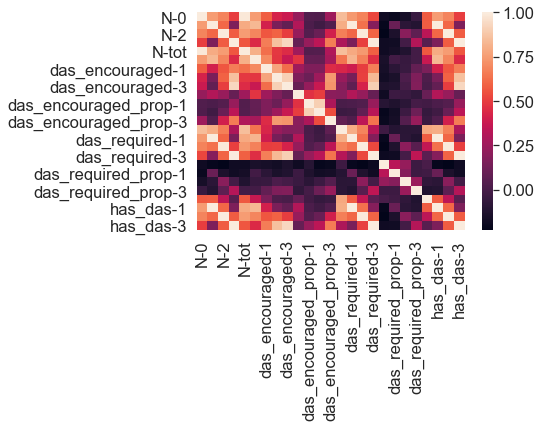

In [22]:
df_journal_das_corr = df_journal_das.corr()

sns.heatmap(df_journal_das_corr)

In [25]:
widgets.Select(
    options=['Linux', 'Windows', 'OSX'],
    value='OSX',
    # rows=10,
    description='OS:',
    disabled=False
)


Select(description='OS:', index=2, options=('Linux', 'Windows', 'OSX'), value='OSX')

In [3]:
widgets.IntSlider()


IntSlider(value=0)